<a href="https://www.kaggle.com/code/ifeanyichukwunwobodo/linkedin-network-analysis-eda-and-graph-theory?scriptVersionId=130767617" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

According to Wikipedia, LinkedIn is a social media platform focused on business and employment launched in 2003. The platform is used for professional networking and carrer development at it stands as a digital labour market that allows job seekers to upload their CV, projects and achievements while employers posts jobs and vacancy. The platform is also used by companies/organisations to announce new products, upgrades and events.


This notebooks explores my personal LinkedIn  account in an attempt to discover patterns in my connections. The dataset was obtained from my LinkedIn account and will not be shared for the sake of privacy. Nonetheless,if youre interested in analysing your data yourself, [this medium artice](https://medium.com/bitgrit-data-science-publication/visualize-your-linkedin-network-with-python-59a213786c4) covered the step-by-step process of obtaining your own personal LinkedIn information. Don't worry prior knowledge of webscraping is not required to obtain data. In fact, even non-data nerds can obtain data from LinkedIn. 

# Question

1. When did I have the most connections?
2. Which company/organisation have the most connections with me?
3. Which position/role/job am i most connected with?
4. What is the connection between the positions I connect with and the companies/organisation?


# The Data

Importing the neccessary dependencies

In [1]:
import pandas as pd 

#For Visualizations
import plotly.express as px 
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#For Natural Language Processing and Text Analysis
import wordcloud 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


#For Network Analysis
import networkx as nx
import community.community_louvain as cl

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Import the data obtained from linked in
df = pd.read_csv('/kaggle/input/connections/Connections.csv', low_memory=False, encoding='utf-8')


# Getting to Know the Data

In [3]:
print('The number of rows in the data is', df.shape[0])
print('The number of columns in the data is', df.shape[1])

The number of rows in the data is 239
The number of columns in the data is 6


In [4]:
df.columns 

Index(['First Name', 'Last Name', 'Email Address', 'Company', 'Position',
       'Connected On'],
      dtype='object')

- First Name: The first name of my connection.

- Last Name: The last name of my connection.

- Email Address: The email address of my connection.

- Company: The company my connection works in.

- Position: This is the job description of my connection.

- Connected On:The date we connected.

In [5]:
df.info() #Getting details of the columns in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     232 non-null    object
 1   Last Name      232 non-null    object
 2   Email Address  7 non-null      object
 3   Company        199 non-null    object
 4   Position       199 non-null    object
 5   Connected On   239 non-null    object
dtypes: object(6)
memory usage: 11.3+ KB


From the above, all of the dataset exists in the right format except the 'Connected On' column which was impoerted as an object instead of date.

In [6]:
df['Connected On'] = pd.to_datetime(df['Connected On'])
df['Connected On'] = df['Connected On'].dt.strftime('%Y-%m-%d')
df['Company'].astype(str)
df['Position'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     232 non-null    object
 1   Last Name      232 non-null    object
 2   Email Address  7 non-null      object
 3   Company        199 non-null    object
 4   Position       199 non-null    object
 5   Connected On   239 non-null    object
dtypes: object(6)
memory usage: 11.3+ KB


Handling the missing values.

In [7]:
df.isna().sum()

First Name         7
Last Name          7
Email Address    232
Company           40
Position          40
Connected On       0
dtype: int64

The missing value is mostly concentrated in the 'Email Address' column. The null values in the 'First Name' and 'Last Name' columns are 7. The 'Company' and 'Position' columns also have the same number of missing values. This might mean that the particular user haas either deleted his/her account or did not give any information when registering the account. This hypothesis is tested below:

In [8]:

df.loc[df['First Name'].isna()]

,First Name,Last Name,Email Address,Company,Position,Connected On
27,NaN,NaN,NaN,NaN,NaN,2022-06-12
75,NaN,NaN,NaN,NaN,NaN,2022-03-05
120,NaN,NaN,NaN,NaN,NaN,2022-01-27
123,NaN,NaN,NaN,NaN,NaN,2022-01-25
140,NaN,NaN,NaN,NaN,NaN,2022-01-14
142,NaN,NaN,NaN,NaN,NaN,2022-01-14
168,NaN,NaN,NaN,NaN,NaN,2021-12-13


It can be seen that values with missing 'First Name' have missing values for all columns  except 'Connected On'. This proves my hypothesis to be correct. The same is also true for Company and Position.

In [9]:
df.drop(['Email Address', 'Last Name'], axis=1, inplace=True)


In [10]:
df.dropna(subset=['Company', 'Position'], inplace=True)

In [11]:
print('Is there any missing values remaining?',df.isna().sum().any())
print('The shape of the dataset after dropping the missing values is', df.shape)

Is there any missing values remaining? False
The shape of the dataset after dropping the missing values is (199, 4)


# 1. When did I have the most connections?

In [12]:
fig = px.histogram(df['Connected On'], nbins=10, title= 'Distrubution of Connections')
fig.update_layout(showlegend=False)

From the histogram above, I had the most connections between January 2021 to July 2022. It can also be seen, that I have not been active recently.

# 2. Which company/organisation have the most connections with me?

In [13]:
company_position = df[['Company', 'Position']
                     ].groupby(by="Company"  #group company and position by company
                              ).count().sort_values(by="Position", ascending =False).head(10) 
company_position

,Position
Company,
"University of Nigeria, Nsukka",7
Side Hustle,5
"Policy Analysis and Research Group (PARG), University of Nigeria",3
Central Bank of Nigeria,2
Centre for the Study of the Economies of Africa (CSEA),2
Afrinvest West Africa,2
"Policy Analysis and Research Group (PARG), UNN",2
SkilledUp Life,1
Self Employed,1


In [14]:
fig=px.bar(company_position, title='Amount of Connections per Company')
fig.update_layout(showlegend=False)

From the bar chart above, it,s clear that University of Nigeria, Nsukka has the highest number of connection followed by Side Hustle and so on.
The bar chart give little information about the companies/organisations with the highest connections. This is because different people have different ways of identifying the same organisation and the different departments in the organisation will not be ientified as one. For example, from the bar chart, one can see that 'Policy Analysis and Research Group (PARG), University of Nigeria' and 'Policy Analysis and Reasearch Group, Univeristy of Nigeria were identified as two different organisations. Also they are also organisations within University of Nigeria, Nsukka.

This requires further analysis using the word cloud.


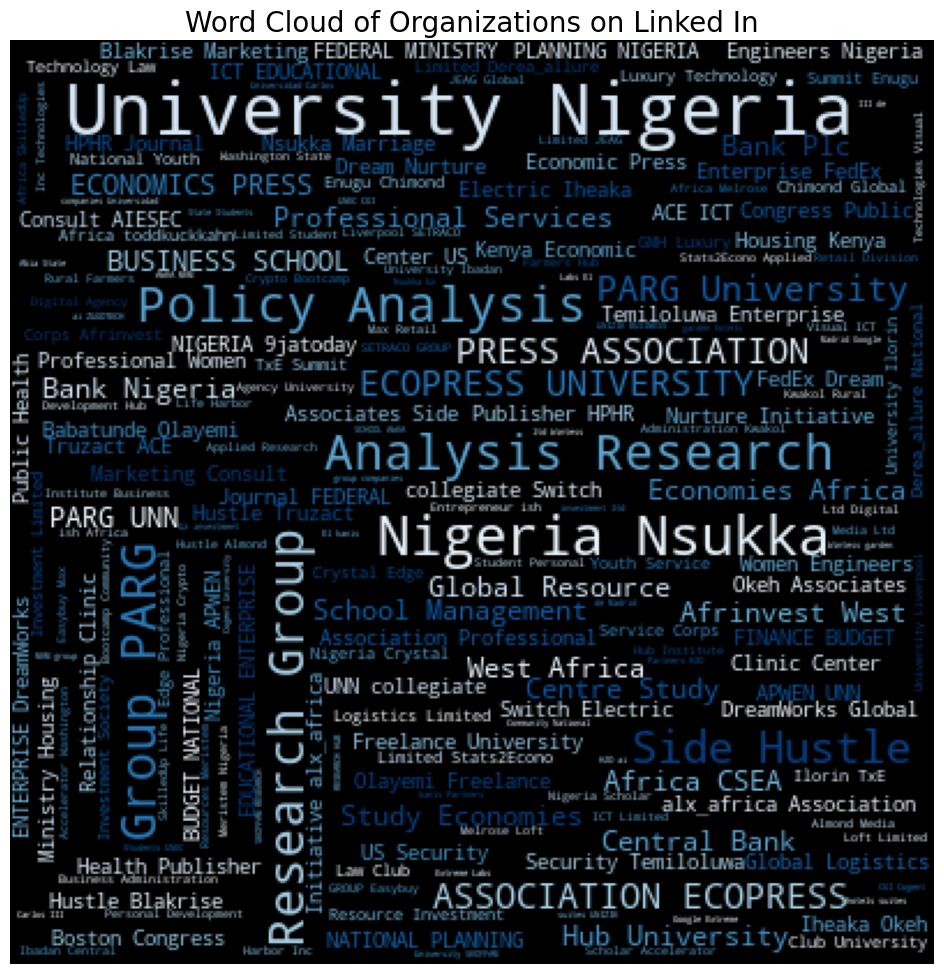

In [15]:
import wordcloud 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['Company_no_stopwords'] = df['Company'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in df['Company_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

plt.subplots(figsize = (12,12))
word = wordcloud.WordCloud(collocation_threshold=4,
                           background_color='black', 
                           width=400, 
                           height=400,
                           colormap='Blues_r').generate(all_words_str)
font_size = 20
plt.imshow(word)
plt.axis('off')
plt.title('Word Cloud of Organizations on Linked In', fontdict={'fontsize': font_size})
plt.savefig('LinkedIn-Word-Clouds.png')
plt.show()

The word cloud also show that the University of Nigeria, Nsukka has the highest frequency.

# 3. Which position/role/job am i most connected with?

In [16]:
df_by_pos = df.groupby(by='Position').count().reset_index().sort_values('First Name', ascending=False)
df_by_pos

,Position,First Name,Company,Connected On,Company_no_stopwords
111,Member,4,4,4,4
25,Co-Founder,3,3,3,3
13,Business Analyst,3,3,3,3
138,Research Assistant,3,3,3,3
89,Intern,3,3,3,3
...,...,...,...,...,...
64,Financial Product Analyst,1,1,1,1
65,Founder,1,1,1,1
66,Founding Executive Director,1,1,1,1
67,Freelancer,1,1,1,1


In [17]:
px.bar(df_by_pos[:20], x='Position', y='First Name', labels={'First Name': 'Count'}, title= 'Top Position in my Connections')

In [18]:
df['Position'].unique()

array(['Real Estate Manager', 'Director of Financial Services', 'Student',
       'Data Analyst Intern',
       'Social Media Manager I Executive Assistant',
       'Finance and Legal Specialist ', 'Intern', 'Visa Consultant',
       'YouTube video creator ', 'Freelancer',
       'Personal Development Coach', 'Chief Executive Officer',
       'Security Supervisor', 'Company Owner', 'C# Developer',
       'HR Business Partner', 'Financial Analyst', 'Technical Secretary',
       'Chief Operating Officer', 'Secretary', 'Data Analyst -intern',
       'Writing Specialist', 'Account Officer', 'Head Artist',
       'Corps Member',
       'Owner (Speaker, Coach, Teacher, Trainer, DEI Certified, DISC Consultant)',
       'Content/Copy Writer | Community Manager ',
       'Head - FinTech Department ', 'Director Events/Programs', 'Member',
       'Volunteer', 'Associate', 'Co-Founder', 'Campus Ambassador',
       'Business Analyst', 'Graduate Student', 'Senior Economist',
       'Investment Strat

It is also important to check the amount of connections related to my area of interest. Because of the isssues faced when analyzing connections. A different approach will be taken. We  check if the positions contains strings related to data science/anlalytical roles and compare them with other areas of interests,

In [19]:
a = [
     'Research Related Roles',
     'Economics Related Roles',
     'Analyst Related Roles',
     'Data Science Related Roles', 
     'Data Related Roles',
     'Finance Related Roles',
     'Statistics Related Roles',
     'Intern'
    ]
b = [
     df["Position"].str.contains("Research").sum(),
     df["Position"].str.contains("Economi").sum(),
     df["Position"].str.contains("Analyst").sum(),
     df["Position"].str.contains("Data Scientist").sum(),
     df["Position"].str.contains("Data").sum(),
     df["Position"].str.contains("Financ").sum(),
     df["Position"].str.contains("Statistic").sum(),
     df["Position"].str.contains("Intern").sum()]
most_significant = pd.DataFrame({'roles':a, 'count': b}).sort_values('count', ascending=False)  
most_significant

,roles,count
2,Analyst Related Roles,16
7,Intern,15
0,Research Related Roles,12
1,Economics Related Roles,10
4,Data Related Roles,7
5,Finance Related Roles,6
3,Data Science Related Roles,3
6,Statistics Related Roles,1


In [20]:
px.bar(most_significant, x='roles',y='count', title='Connections by Industries of Interest')

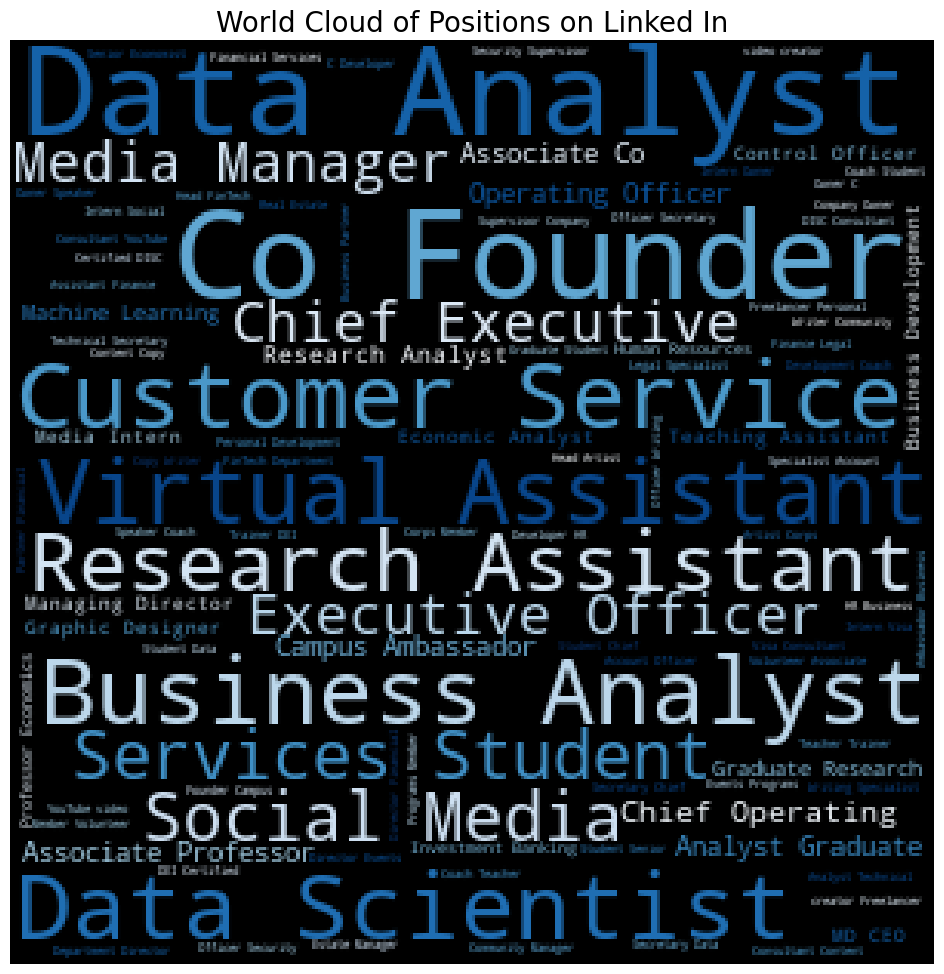

In [21]:
df['position_no_stopwords'] = df['Position'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words_in_position = list([a for b in df['position_no_stopwords'].tolist() for a in b])
all_words_pos = ' '.join(all_words_in_position)

plt.subplots(figsize = (12,12))
word_pos = wordcloud.WordCloud(collocation_threshold=3,
                               background_color='black', 
                               width=300, 
                               height=300,
                               colormap='Blues').generate(all_words_pos)
font_size = 20
plt.imshow(word_pos)
plt.axis('off')
plt.title('World Cloud of Positions on Linked In', fontdict={'fontsize': font_size})
plt.savefig('LinkedIn-Word-Cloud.png')
plt.show()

From the word cloud, it can be seen that Data Analyst, Business Analyst, Virtual Assistant and co founder are common occupation of my connections.

# 4. What is the connection between the positions I connect with and the companies/organisation

In [22]:
df['My Network'] = 'My Network'
fig = px.treemap(df, 
                 path=['My Network', 'Company', 'Position'],
                 width=1000, 
                 height=1000,
                 title= 'Treemap Showing the Relationship Between the Organization and Positions')
fig.show()

This shows the various positions in each company. For example, under University of Niegeria, Nsukka, I am connected to students, lecturers, graduate trainnees and teaching assistants.
We can also check the company with different positions:

In [23]:
fig = px.treemap(df, path=['My Network', 'Position', 'Company'], width=1000, height=1000)
fig.show()

The treemap shows the positions I am connected to in each organisation. But the web of relationship between the organisations and positions remains unclear.
To answer this, I will use network charts. A network is a map that shows relationship between different objects.

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from current font.



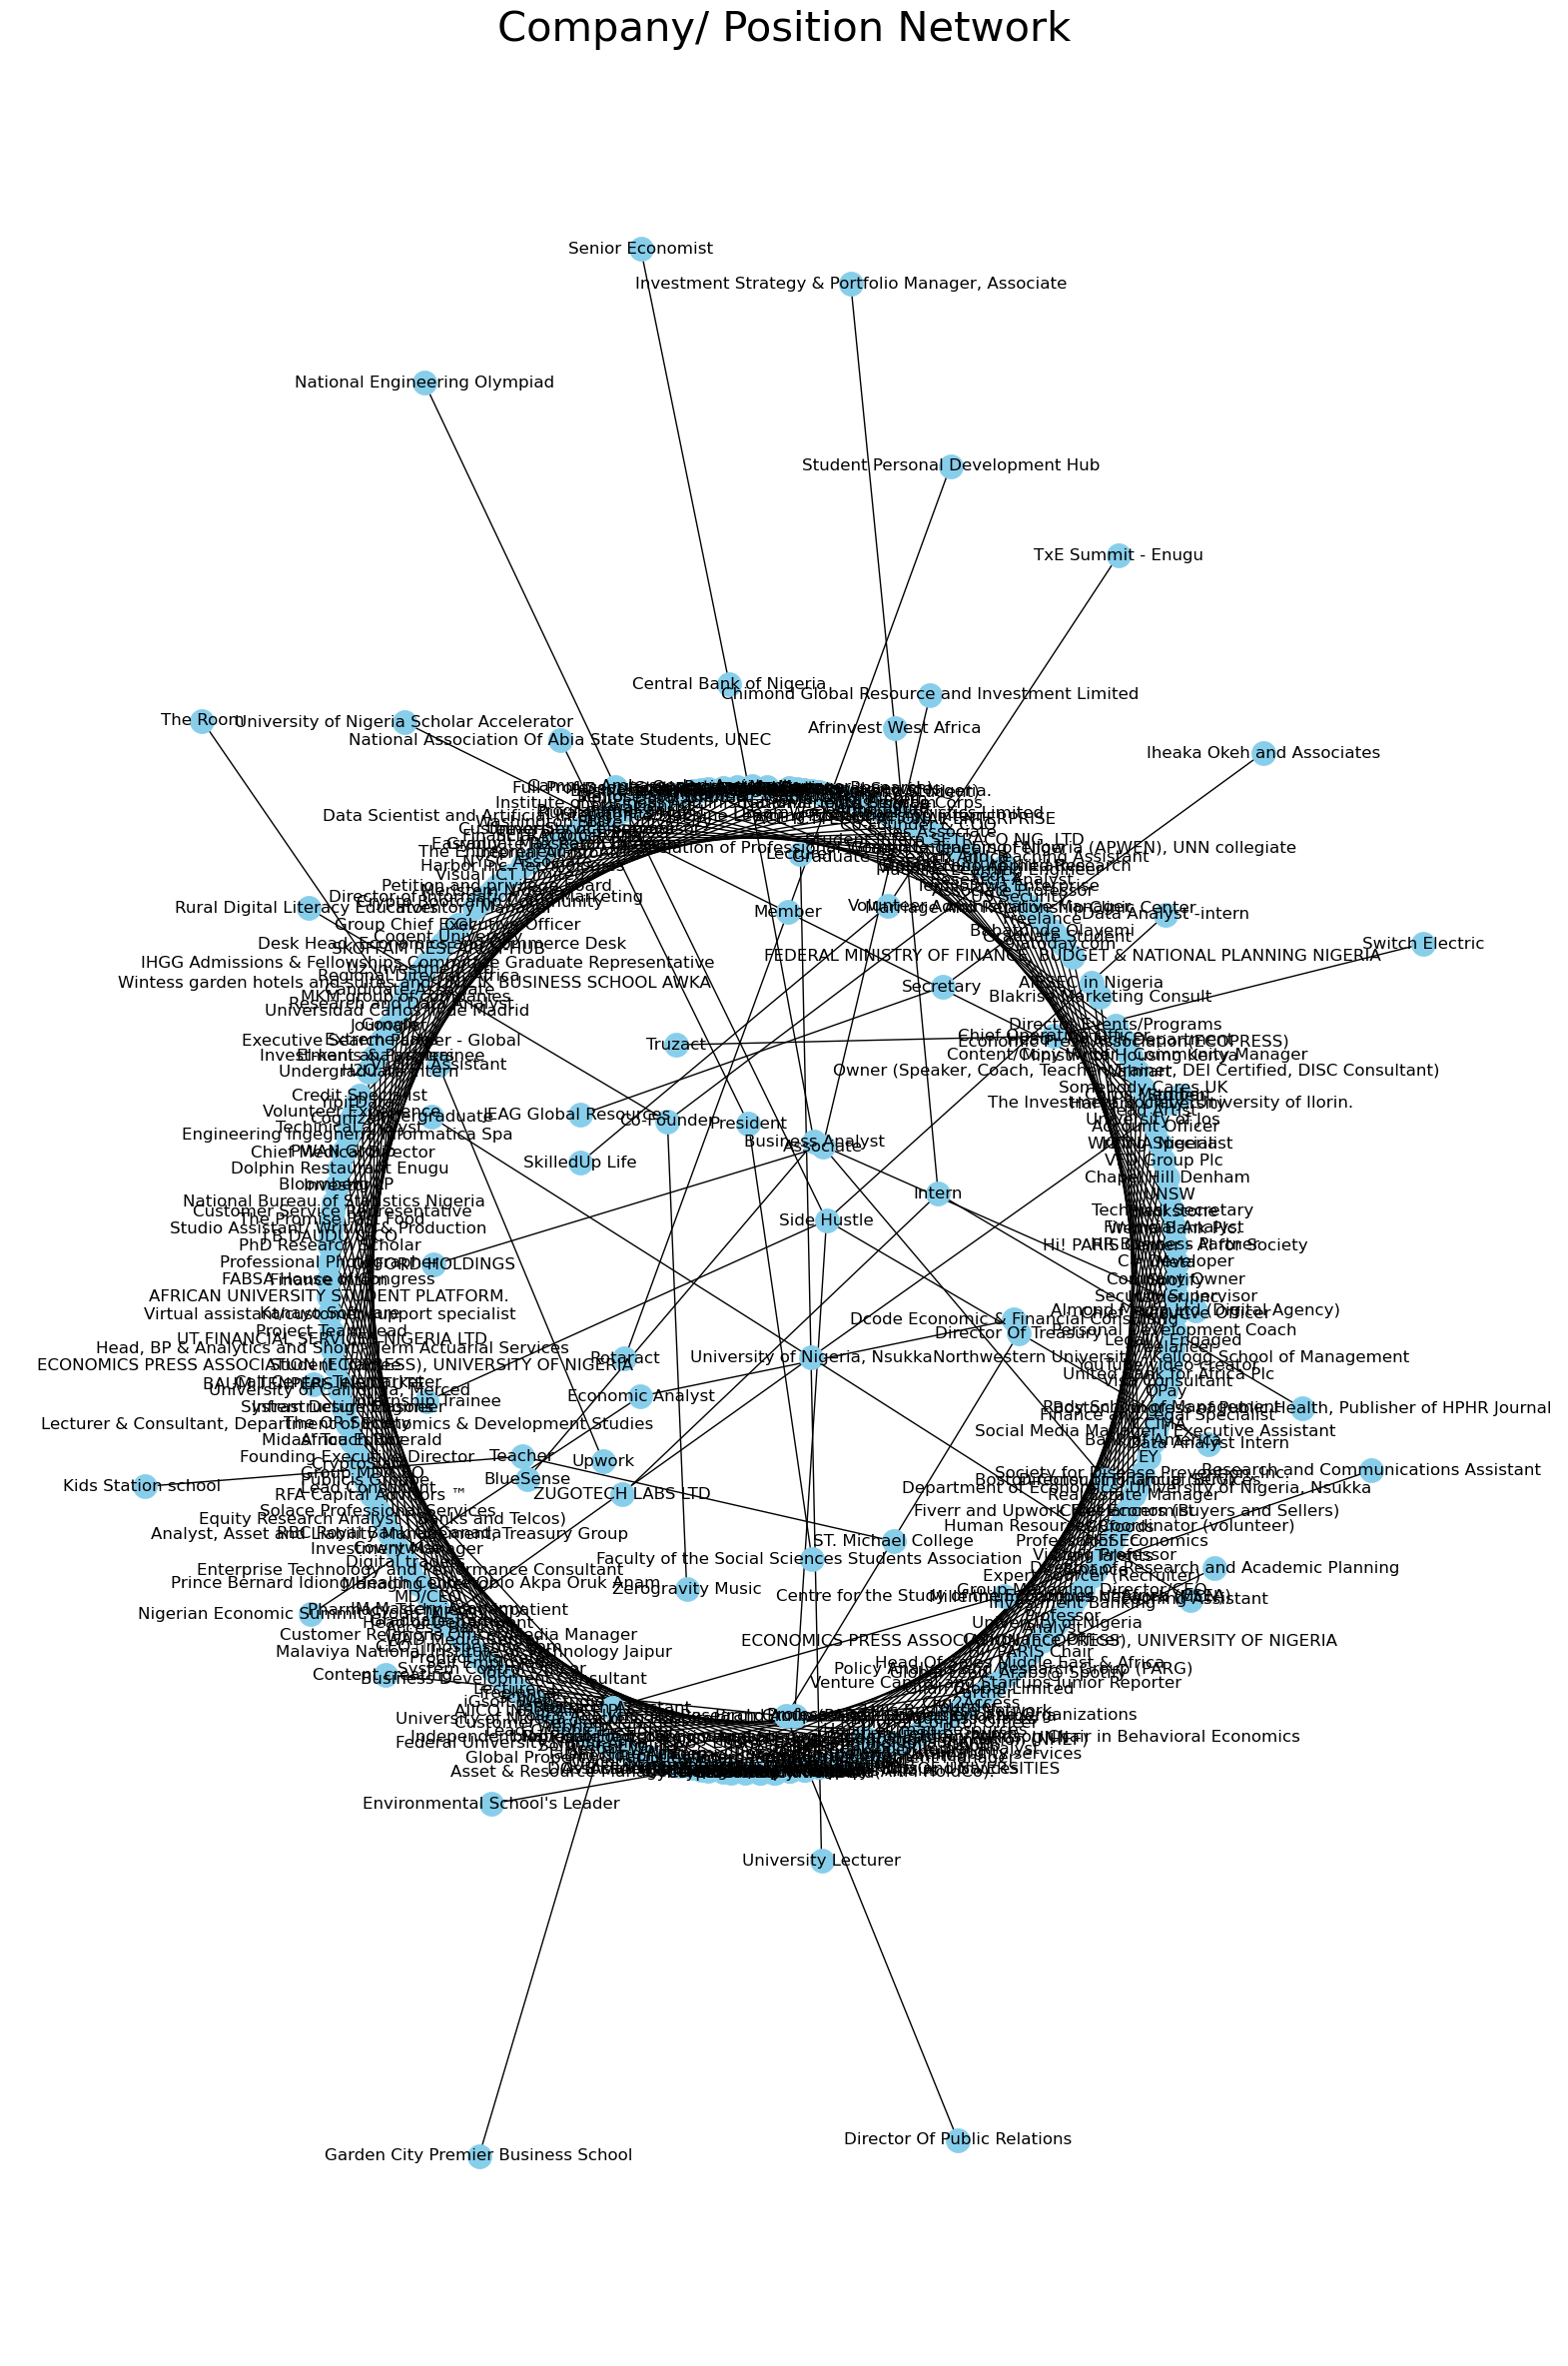

In [24]:

G = nx.from_pandas_edgelist(df,source= 'Position', target='Company', edge_attr=True, create_using=nx.Graph())

plt.rcParams['figure.figsize']  = (20, 30)
plt.style.use('ggplot')
plt.title('Company/ Position Network', fontsize = 30)
plt.grid()
plt.axis('off')



pos=nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=cm.Blues, pos=pos)
plt.show()

This looks messy and unclear. Let's try that again with pyvis.

In [25]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.8 MB/s eta 0:00:00


In [26]:
#!pip install pyvis (if not installed previously)
from pyvis.network import Network
net = Network(notebook= True,cdn_resources='in_line', width="1000px", height="700px", bgcolor='#222222', font_color='white')
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show('linked.html')


linked.html


Although Networks showed a lot of leaves and nodes, the pyvis visualisation shows that we have a a less connected network 

We can check for the degree centrality of the network. Degree centrality shows the number of connections a node has.

In [27]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Real Estate Manager': 0.002785515320334262,
 'Ministry of Housing Kenya': 0.002785515320334262,
 'Director of Financial Services': 0.002785515320334262,
 'Economic Press Association(ECOPRESS)': 0.002785515320334262,
 'Student': 0.002785515320334262,
 'University of Nigeria, Nsukka': 0.016713091922005572,
 'Data Analyst Intern': 0.002785515320334262,
 'Side Hustle': 0.013927576601671309,
 'Social Media Manager I Executive Assistant': 0.002785515320334262,
 'Blakrise Marketing Consult': 0.002785515320334262,
 'Finance and Legal Specialist ': 0.002785515320334262,
 'AIESEC in Nigeria': 0.002785515320334262,
 'Intern': 0.008356545961002786,
 'Boston Congress of Public Health, Publisher of HPHR Journal': 0.002785515320334262,
 'Visa Consultant': 0.002785515320334262,
 'FEDERAL MINISTRY OF FINANCE, BUDGET & NATIONAL PLANNING NIGERIA': 0.002785515320334262,
 'YouTube video creator ': 0.002785515320334262,
 '9jatoday.com ': 0.002785515320334262,
 'Freelancer': 0.002785515320334262,
 'Babatun

In [28]:
degree_df=nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
fig = px.bar(degree_df.sort_values('centrality', ascending=False).head(10))
fig.update_layout(showlegend=False)

This shows that University of Nigeria, Nsukka has the most number of connections (nodes), followed by side hustle and member. These were also the top to organization and positions in my network.

Let's check if our result emains consistent with other measures of centrality.
* Betweeness Centrality checks how a nodes serves as a broker between other nodes. That is, how much time a node serves as a bridge among the shortest path between two other nodes.
Closeness Centrality shows how fast a node can pass information within a network.

In [29]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])

fig = px.bar(betweenness_df.sort_values('centrality', ascending=False).head(10))
fig.update_layout(showlegend=False)

In [30]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

fig = px.bar(closeness_df.sort_values('centrality', ascending=False).head(10))
fig.update_layout(showlegend=False)

The results of the betwenness and closeness centrality are the same with that of degree centrality. Let's add the centrality as attributes of our network.

In [31]:
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'between_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')


Sepearate the nodes of the network into communities using the community library.

In [32]:
communities = cl.best_partition(G)
communities

{'Real Estate Manager': 0,
 'Ministry of Housing Kenya': 0,
 'Director of Financial Services': 1,
 'Economic Press Association(ECOPRESS)': 1,
 'Student': 2,
 'University of Nigeria, Nsukka': 2,
 'Data Analyst Intern': 3,
 'Side Hustle': 3,
 'Social Media Manager I Executive Assistant': 4,
 'Blakrise Marketing Consult': 4,
 'Finance and Legal Specialist ': 5,
 'AIESEC in Nigeria': 5,
 'Intern': 24,
 'Boston Congress of Public Health, Publisher of HPHR Journal': 24,
 'Visa Consultant': 7,
 'FEDERAL MINISTRY OF FINANCE, BUDGET & NATIONAL PLANNING NIGERIA': 7,
 'YouTube video creator ': 8,
 '9jatoday.com ': 8,
 'Freelancer': 9,
 'Babatunde Olayemi': 9,
 'Personal Development Coach': 10,
 'Freelance': 10,
 'Chief Executive Officer': 11,
 'Marriage And Relationship Clinic Center': 11,
 'Security Supervisor': 12,
 'US Security': 12,
 'Company Owner': 13,
 'Temiloluwa Enterprise': 13,
 'C# Developer': 14,
 'FedEx': 14,
 'HR Business Partner': 15,
 'Dream Nurture Initiative': 15,
 'Financial An

The communities can also be added to the attributes of the network.

In [33]:
nx.set_node_attributes(G, communities, 'group')

Visualizing the network:

In [34]:
com_net = Network(notebook = True,
                  cdn_resources='remote',
                  width='1000px', 
                  height ='700px',
                  bgcolor='#222222', 
                  font_color='white')
com_net.from_nx(G)
com_net.show('LinkedIn_Network.html')

LinkedIn_Network.html


The network does not show any clear cluster between the various communities. This means that there is no clear connection between the organizations and jobs in my network. That is my LinkedIn network is a sparse network.

We can measure this quantitatively through network transitivity or clustering coefficient of a network. The transitivity or clustering coefficient of a network is a measure of the tendency of the nodes to cluster together.

In [35]:
print(nx.transitivity(G))

0


This shows that there is zero probability of the network joining together.

## Summary
In this notebook, we had a quick overview of my network analysis using my LinkedIn data. Exploratory Data Analysis and Network analysis was employed which revealed that I need to become more deliberate with my activities on LinkedIn as my network was shown to have no connection whatsoever.  This was also supported by the fact that I have had little to no activity (connections) in recent period. 
The network analysis showed that there is no relationship between my the organisation and position they work for. This might be because my connections describe the same job with different words. Another reason is that I connect with different roles in the same companies. That is, my connections are nt the result of a targeted effort. 


# Conclusion
   This notebook only gives a brief introduction to network analysis and graph theory. You can learn more about the technique check this [QuantEcon tutorial](https://datascience.quantecon.org/applications/networks.html).
   I hope this notebook inspires your next project. If you found this notebook helpful, leave an upvote or share. Thank you!